In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2
import json
import keras

In [ ]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 0.6 sometimes works better for folks
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [34]:
%%capture captured
res_model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

In [29]:
train_path='../sample/image_caption_train_dict.json'

In [30]:
train_captions = json.load(open(train_path,'r'))

In [31]:
path = "../dataset/images/"

In [32]:
for each in train_captions.keys():
    captions = train_captions[each]
    for i in range(len(captions)):
        captions[i] =  "<start> " + f"{captions[i]}".strip() + " <end>"

In [ ]:
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = res_model.predict(x)
  train_features[image_name]=features.squeeze()

 14%|█▍        | 1130/8092 [18:09<13:27:37,  6.96s/it]

In [ ]:
all_captions=[]
for img_id in train_captions:
  for captions in train_captions[img_id]:
    all_captions.append(captions)
all_words=" ".join(all_captions)
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

In [ ]:
vocab_size=len(unique_words)+1
max_length=40

In [ ]:
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [ ]:
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

In [ ]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in train_encoded_captions:
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import  LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

In [ ]:
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
epochs=5
no_of_photos=1
steps=len(train_encoded_captions)
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  if i%10 == 0:
      model.save(f"model_f{i}.h5")

In [25]:
model.save(f"model_50.h5")

In [26]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  return final

['A', 'hiker', 'in', 'short', 'and', 'a', 'person', 'be', 'climb', 'up', 'a', 'hill', '.']


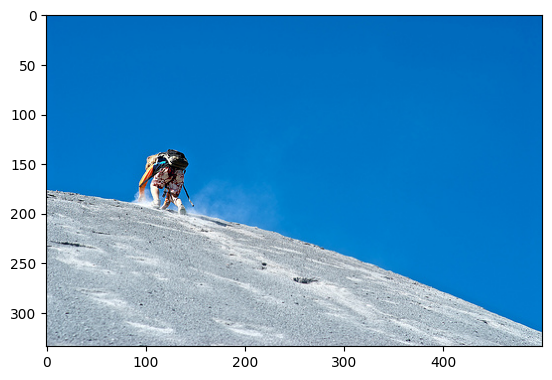

['Three', 'boy', 'play', 'with', 'a', 'newspaper', '.']


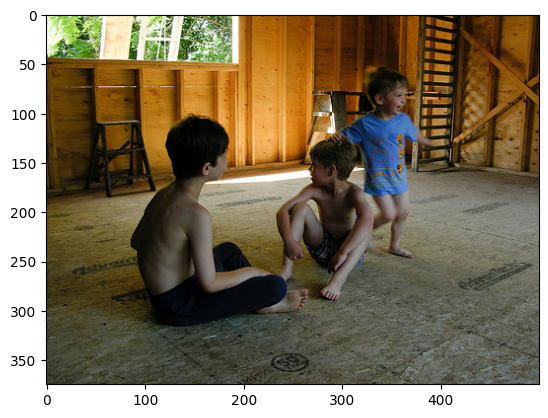

['Group', 'of', 'protester', 'picket', 'in', 'a', 'building', '.']


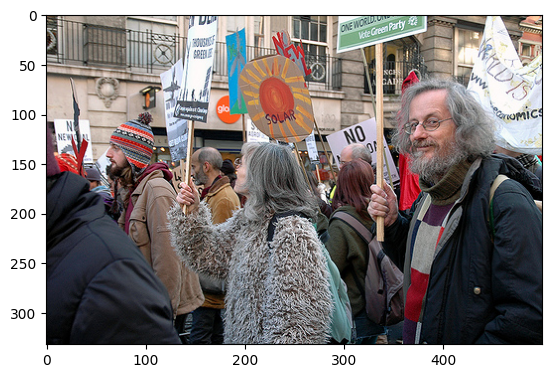

['A', 'helmeted', 'man', 'be', 'skateboard', 'down', 'a', 'skateboard', 'in', 'the', 'air', '.']


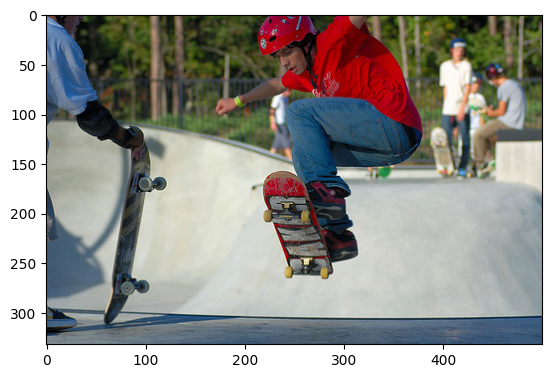

['A', 'blueish', 'green', 'car', 'on', 'a', 'dirt', 'road', 'splash', 'mud', 'on', 'a', 'muddy', 'road', '.']


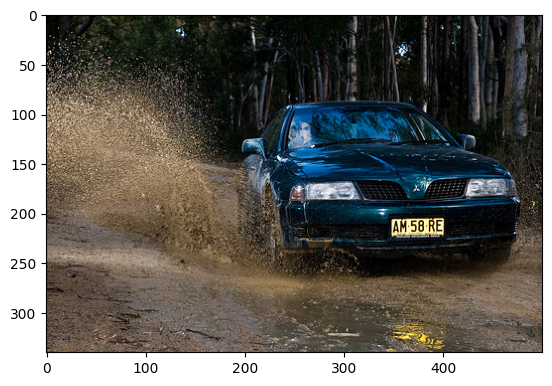

['A', 'city', 'street', 'with', 'a', 'market']


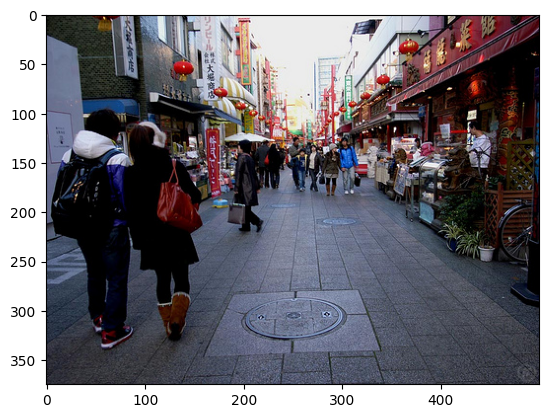

['A', 'little', 'girl', 'do', 'a', 'faucet', '.']


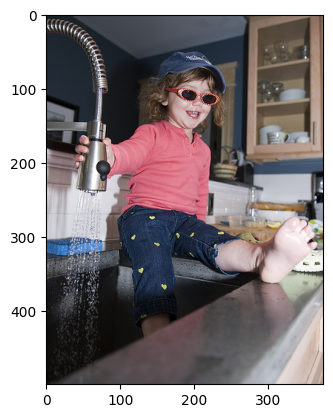

['A', 'man', 'with', 'a', 'pug', 'dog', 'bend', 'down', 'to', 'pick', 'a', 'leash', 'in', 'a', 'leash', 'rummage', 'their', 'owner', 'rummage', 'while', 'merchandise', '.']


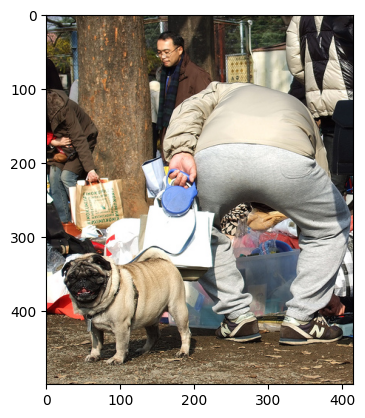

['A', 'man', 'be', 'climb', 'a', 'mountain', '.']


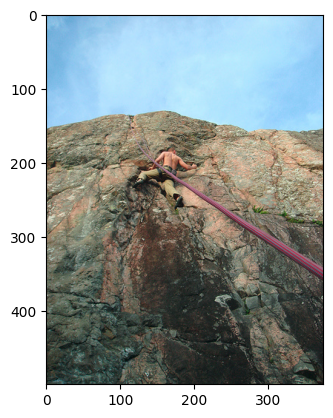

['A', 'woman', 'in', 'sunglasses', 'and', 'a', 'brown', 'coat', 'and', 'sunglasses', 'and', 'a', 'woman', 'in', 'white', 'walk', 'and', 'he', 'walk', 'away', '.']


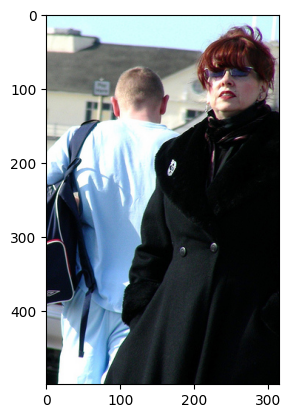

['A', 'football', 'player', 'in', 'red', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'and', 'white', 'team', 'be', 'pose', '.']


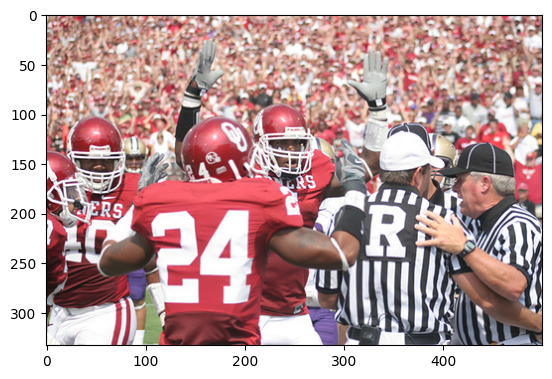

['People', 'be', 'rock', 'climb']


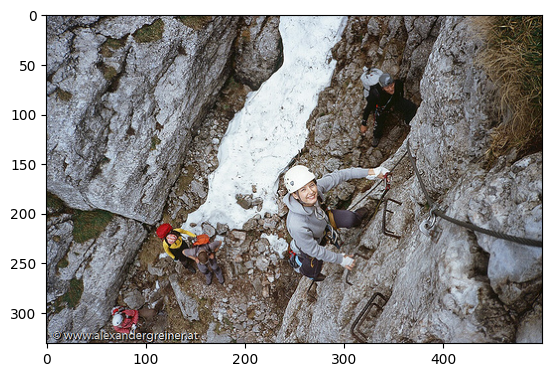

['A', 'light', 'light', 'dog', 'punch', 'a', 'woman', '.']


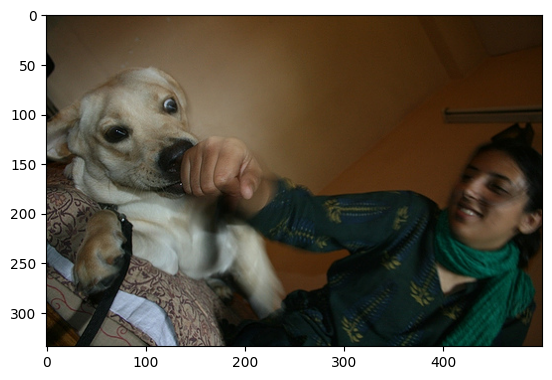

['A', 'man', 'be', 'skip', 'through', 'the', 'water', '.']


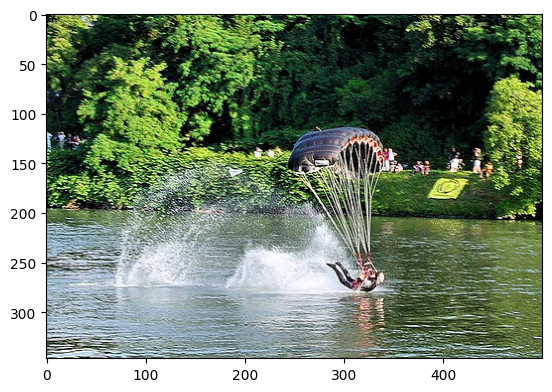

['A', 'dog', 'in', 'garden', '.']


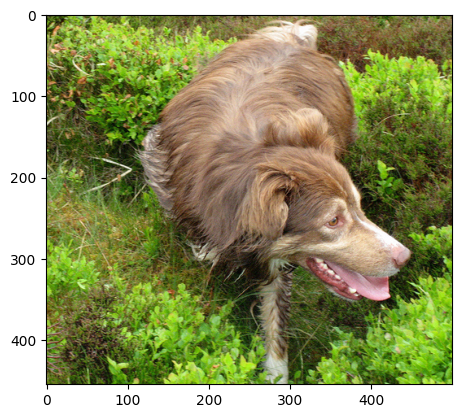

['A', 'woman', 'in', 'a', 'red', 'coat', 'be', 'smile', 'while', 'person', 'in', 'the', 'background', 'be', 'walk', 'down', 'a', 'park', '.']


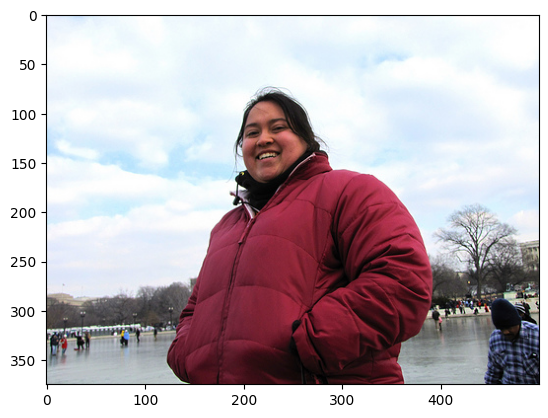

['A', 'girl', 'in', 'a', 'red', 'dress', 'kick', 'into', 'the', 'air', '.']


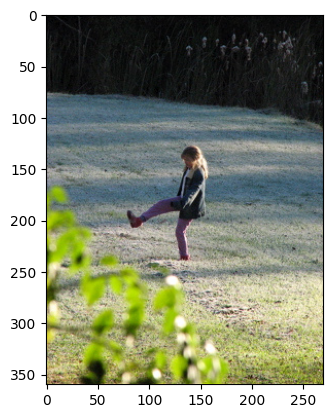

['A', 'tan', 'and', 'white', 'dog', 'lay', 'on', 'a', 'grassy', 'field', '.']


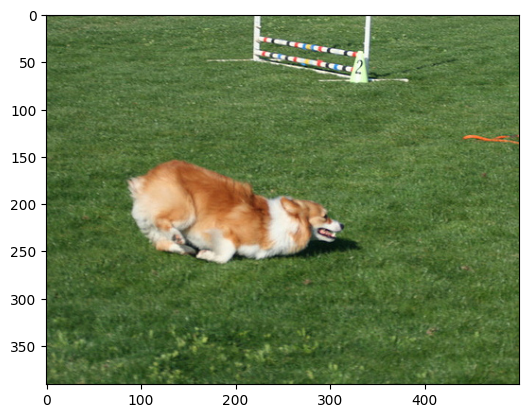

['A', 'man', 'in', 'a', 'white', 'and', 'white', 'skinned', 'woman', 'be', 'jump', 'for', 'a', 'ball', 'for', 'a', 'ball', '.']


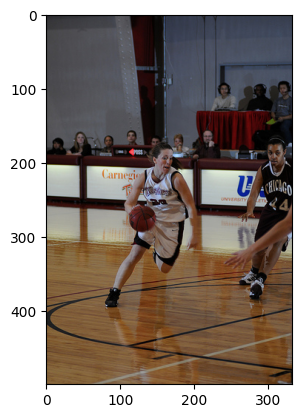

['A', 'man', 'be', 'stand', 'on', 'a', 'sidewalk', 'with', 'a', 'man', 'in', 'gray', '.']


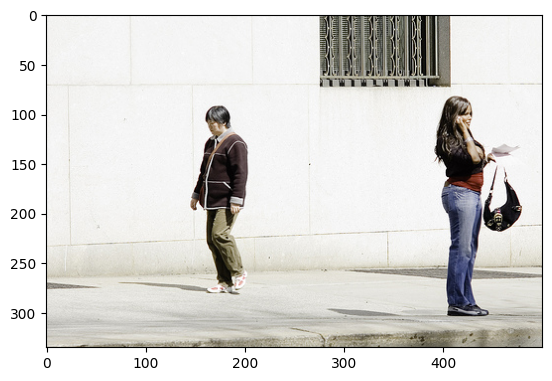

In [28]:
for img_id in list(train_features.keys())[20:40]:
    img=cv2.imread(path+img_id)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
    photo=train_features[img_id]
    candidate=greedy_search(photo)
    print(candidate)
    plt.show()